<h1>Домашнее задание к вебинару 3<h1>

#### Задание 1. Постройте нейронную сеть (берем несложную полносвязную сеть, меняем число слоев, число нейронов, типы активации, тип оптимизатора) на датасете from sklearn.datasets import load_boston.

In [190]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import r2_score


import warnings
warnings.filterwarnings('ignore')

In [265]:
X, y = load_boston(return_X_y=True)

X =  pd.DataFrame(X, columns=load_boston().feature_names)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
display(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(354, 13)

(152, 13)

(354,)

(152,)

In [266]:
X.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT'],
      dtype='object')

In [267]:
X_train.head(4)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21
116,0.13158,0.0,10.01,0.0,0.547,6.176,72.5,2.7301,6.0,432.0,17.8,393.30,12.04
45,0.17142,0.0,6.91,0.0,0.448,5.682,33.8,5.1004,3.0,233.0,17.9,396.90,10.21
16,1.05393,0.0,8.14,0.0,0.538,5.935,29.3,4.4986,4.0,307.0,21.0,386.85,6.58


In [268]:
print('Number of unique names by columns')
for column in X_train.columns:
  print(f'{column}: {X_train[column].nunique()}')

Number of unique names by columns
CRIM: 353
ZN: 23
INDUS: 69
CHAS: 2
NOX: 80
RM: 323
AGE: 274
DIS: 301
RAD: 9
TAX: 61
PTRATIO: 43
B: 253
LSTAT: 327


In [311]:
class ColSelector(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.col]

class CatSelector(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.col]]

In [310]:
# Age - категориальный признак, который можно закодировать порядковыми номерами, далее стандартизируем эти номера,
# поскольку значений возраста очень много
class AgeCoding(BaseEstimator, TransformerMixin):
    def __init__(self, col):
        self.col = col

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X['age_code'] == 0
        num_code_age = 0
        for age in X[self.col].sort_values().unique():
            X.loc[X[self.col] == age, 'age_code'] == num_code_age
        return X[['age_code']]

In [314]:
age_coder = Pipeline([
                      ('selector', CatSelector("AGE")),
                      ('age_coding', AgeCoding('AGE')),
                      ('scaler', StandardScaler())
])

In [315]:
scaler_transform =  Pipeline([
                ('selector', ColSelector(X.columns)),
                ('standard', StandardScaler())
            ])

In [317]:
transformer = FeatureUnion([('cat_transformer', age_coder),
                     ('num_transformer', num_transformer)])

In [318]:
X_tr = transformer.fit_transform(X_train)
X_tst = transformer.transform(X_test)

In [319]:
X_tr.shape, X_tst.shape

((354, 13), (152, 13))

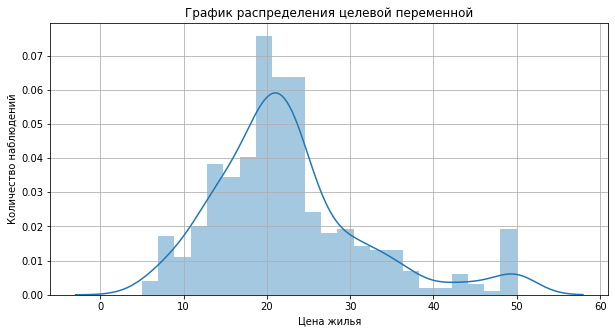

In [320]:
from seaborn import distplot
plt.figure(figsize=(10, 5))
distplot(y)
plt.grid()

plt.xlabel('Цена жилья')
plt.ylabel('Количество наблюдений')
plt.title('График распределения целевой переменной')
plt.show()

Очевидны небольшие выбросы в правой части графика.

Переходим к построению нейронной сети. В данном случае мы решаем задачу регрессии (важно при выборе функции активации)

In [297]:
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError

In [399]:
my_nn = Sequential([
    Dense(70, activation='relu', input_shape=(13,)), 
    Dense(60, activation='linear'), 
    Dense(40, activation='relu'), 
    Dense(1, activation='relu')
])

my_nn.compile(optimizer=Adam(),
              loss = MeanSquaredError(),
              metrics = [tf.keras.metrics.MeanSquaredError()])

history = my_nn.fit(X_tr, y_train,
                    epochs=50,
                    batch_size=10,
                    validation_data=(X_tst, y_test),
                    verbose = 0)


In [400]:
my_nn.summary()

Model: "sequential_33"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_133 (Dense)           (None, 70)                980       
                                                                 
 dense_134 (Dense)           (None, 60)                4260      
                                                                 
 dense_135 (Dense)           (None, 40)                2440      
                                                                 
 dense_136 (Dense)           (None, 1)                 41        
                                                                 
Total params: 7,721
Trainable params: 7,721
Non-trainable params: 0
_________________________________________________________________


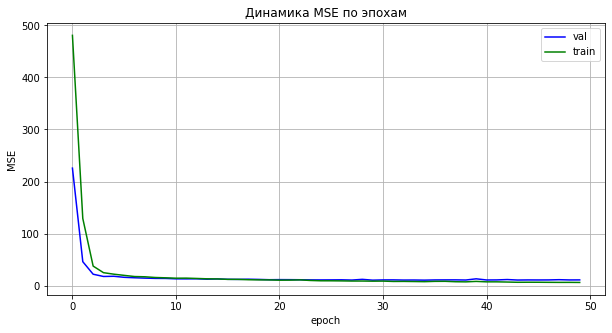

In [401]:
plt.figure(figsize=(10,5))
plt.plot(history.history['val_mean_squared_error'], label='val', c='blue')
plt.plot(history.history['mean_squared_error'], label='train', c='green')
plt.legend()
plt.xlabel('epoch')
plt.ylabel('MSE')
plt.title('Динамика MSE по эпохам')
plt.grid()
plt.show()

Видна динамика уменьшения ошибки

In [402]:
y_pred = my_nn.predict(X_tst) 
y_pred[:3] # на выходе двумерный массив

array([[27.025982],
       [36.218582],
       [16.761774]], dtype=float32)

In [403]:
y_pred = y_pred.reshape(-1,) #перевод в одномерный массив
y_pred[:3]

array([27.025982, 36.218582, 16.761774], dtype=float32)

In [404]:
# Расчет метрики R2
print(f"R2 score: {r2_score(y_test, y_pred)}")

R2 score: 0.8509443741676739


#### Задание 2. Постройте 10-15 вариантов разных нейронных сетей и сведите результаты их работы в таблицу. Опишите, какого результата вы добились от нейросети? Что помогло вам улучшить ее точность?

In [571]:
# Пропишем словарь - заготовку
models_evaluation = {'model No':[],
                     'neuron 1st hidden layer quantity': [],
                     'number of epochs': [],
                     'optimizer': [],
                     'train r2 score': [],
                     'val r2 score': [],
                     'mse': [],
                     'val mse': []}

In [572]:
def eval_model(X_train, y_train, epoch, val_data = (X_tst, y_test)):
    h = model.fit(X_tr, y_train, epochs=epoch, validation_data = val_data, verbose=0)
    test_loss, test_r2 = model.evaluate(X_tst, y_test, verbose=0)
    r2_tr = r2_score(y_train, model.predict(X_tr).reshape(-1, ))
    r2_val = r2_score(y_test, model.predict(X_tst).reshape(-1, ))

    mse_tr = h.history["mean_squared_error"][-1]
    mse_val = h.history["val_mean_squared_error"][-1]

    print(f'\tMSE на трейне : {mse_tr:.4f};\n'
          f'\tMSE на валидационной выборке : {mse_val:.4f};\n'
          f'\tR2 score на трейне :  {r2_tr:.4f};\n'
          f'\tR2 score на валидационной выборке ; {r2_val:.4f}')
    
    return mse_tr, mse_val, r2_tr, r2_val

Сначала изучим влияние на метрики количества нейронов первого внутреннего слоя и числа эпох. Количество слоев дополнительно исследовать не будем - я его подобрала в первом задании. Изучим другие параметры на одной структуре сети

In [573]:
neurons  = [60, 100, 150, 200]
epochs = [30, 50, 100]


number_of_model = 1

for neuron in neurons:
    for epoch in epochs:

        model = Sequential([Dense(neuron, activation='relu', input_shape=(13,)),
                            Dense(int(neuron/1.3), activation='linear'),
                            Dense(int(neuron/1.5), activation='relu'),
                            Dense(1, activation='relu')])

        model.compile(optimizer = 'adam',
                      loss = MeanSquaredError(),
                      metrics =[tf.keras.losses.MeanSquaredError()])

        print(f'Количество нейронов в первом внутреннем слое - {neuron}, '
              f'Количество эпох - {epoch}:')

        mse_tr, mse_val, r2_tr, r2_val = eval_model(X_tr, y_train, epoch)
        print('*' * 50)

        models_evaluation['model No'].append(f'model_{number_of_model}')
        models_evaluation['neuron 1st hidden layer quantity'].append(neuron)
        models_evaluation['number of epochs'].append(epoch)
        models_evaluation['optimizer'].append('Adam')
        models_evaluation['train r2 score'].append(r2_tr)
        models_evaluation['val r2 score'].append(r2_val)
        models_evaluation['mse'].append(f'{mse_tr:.4f}')
        models_evaluation['val mse'].append(f'{mse_val:.4f}')


        number_of_model+=1

Количество нейронов в первом внутреннем слое - 60, Количество эпох - 30:
	MSE на трейне : 12.6151;
	MSE на валидационной выборке : 14.2160;
	R2 score на трейне :  0.8587;
	R2 score на валидационной выборке ; 0.8061
**************************************************
Количество нейронов в первом внутреннем слое - 60, Количество эпох - 50:
	MSE на трейне : 9.4852;
	MSE на валидационной выборке : 12.3959;
	R2 score на трейне :  0.8880;
	R2 score на валидационной выборке ; 0.8302
**************************************************
Количество нейронов в первом внутреннем слое - 60, Количество эпох - 100:
	MSE на трейне : 6.5416;
	MSE на валидационной выборке : 10.7068;
	R2 score на трейне :  0.9276;
	R2 score на валидационной выборке ; 0.8536
**************************************************
Количество нейронов в первом внутреннем слое - 100, Количество эпох - 30:
	MSE на трейне : 12.8730;
	MSE на валидационной выборке : 14.9631;
	R2 score на трейне :  0.8582;
	R2 score на валидационной выбо

In [574]:
best_ind = np.argmax(models_evaluation['val r2 score'])

In [575]:
print(f"Лучшее количество нейронов: {models_evaluation['neuron 1st hidden layer quantity'][best_ind]}\n"
      f"Лучшее количество эпох: {models_evaluation['number of epochs'][best_ind]}\n"
      f"Лучшее значение r2 на тестовых данных: {models_evaluation['val r2 score'][best_ind]:.4f}\n"
      f"Значение r2 на тренировочных данных: {models_evaluation['train r2 score'][best_ind]:.4f}")

Лучшее количество нейронов: 60
Лучшее количество эпох: 100
Лучшее значение r2 на тестовых данных: 0.8536
Значение r2 на тренировочных данных: 0.9276


Хоть метрика и высокая, хотя есть и переобучение. Посмотрим все результаты

In [576]:
pd.DataFrame(models_evaluation, 
             columns = models_evaluation.keys())

,model No,neuron 1st hidden layer quantity,number of epochs,optimizer,train r2 score,val r2 score,mse,val mse
0,model_1,60,30,Adam,0.858671,0.806050,12.6151,14.2160
1,model_2,60,50,Adam,0.888027,0.830244,9.4852,12.3959
2,model_3,60,100,Adam,0.927589,0.853647,6.5416,10.7068
3,model_4,100,30,Adam,0.858164,0.797544,12.8730,14.9631
4,model_5,100,50,Adam,0.887421,0.817172,9.5842,13.3308
5,model_6,100,100,Adam,0.920204,0.836541,6.6778,11.9051
6,model_7,150,30,Adam,0.884305,0.832585,11.1030,12.2322
7,model_8,150,50,Adam,0.925395,0.843858,6.7934,11.4242
8,model_9,150,100,Adam,0.937570,0.847025,3.8833,11.1768
9,model_10,200,30,Adam,0.888633,0.835583,11.1383,12.0014


Итаr, наилучший результат дает модель 3, будем использовать ее параметры


   
     
       
Теперь изучим влияние на результат разных оптимизаторов.

In [596]:
tf.random.set_seed(42)

lr = 1e-3

for optim in [tf.keras.optimizers.SGD(learning_rate=lr),
              tf.keras.optimizers.RMSprop(learning_rate=lr),
              tf.keras.optimizers.Adam(learning_rate=lr),
              tf.keras.optimizers.Nadam(learning_rate=lr)]:
              
              
    model = Sequential([Dense(60, activation='relu', input_shape=(13,)),
                      Dense(50, activation='linear'),
                      Dense(40, activation='relu'),
                      Dense(1, activation='relu')])
    
    model.compile(optimizer=optim,
                  loss= MeanSquaredError(),
                  metrics=[tf.keras.losses.MeanSquaredError()])

    print(f'Оптимайзер {type(optim).__name__}:')

    mse_tr, mse_val, r2_tr, r2_val = eval_model(X_tr, y_train, epoch = 100)
    print('*' * 50)

    models_evaluation['model No'].append(f'model_{number_of_model}')
    models_evaluation['neuron 1st hidden layer quantity'].append(neuron)
    models_evaluation['number of epochs'].append(epoch)
    models_evaluation['optimizer'].append(f"{type(optim).__name__}")
    models_evaluation['train r2 score'].append(r2_tr)
    models_evaluation['val r2 score'].append(r2_val)
    models_evaluation['mse'].append(f'{mse_tr:.4f}')
    models_evaluation['val mse'].append(f'{mse_val:.4f}')


    number_of_model+=1

Оптимайзер SGD:
	MSE на трейне : 5.0214;
	MSE на валидационной выборке : 10.7185;
	R2 score на трейне :  0.9393;
	R2 score на валидационной выборке ; 0.8530
**************************************************
Оптимайзер RMSprop:
	MSE на трейне : 5.5664;
	MSE на валидационной выборке : 12.2455;
	R2 score на трейне :  0.9236;
	R2 score на валидационной выборке ; 0.8318
**************************************************
Оптимайзер Adam:
	MSE на трейне : 6.9373;
	MSE на валидационной выборке : 12.3611;
	R2 score на трейне :  0.9211;
	R2 score на валидационной выборке ; 0.8318
**************************************************
Оптимайзер Nadam:
	MSE на трейне : 6.4034;
	MSE на валидационной выборке : 10.8322;
	R2 score на трейне :  0.9223;
	R2 score на валидационной выборке ; 0.8524
**************************************************


In [597]:
best_ind = np.argmax(models_evaluation['val r2 score'])
print(f"Лучшее количество нейронов: {models_evaluation['neuron 1st hidden layer quantity'][best_ind]}\n"
      f"Лучшее количество эпох: {models_evaluation['number of epochs'][best_ind]}\n"
      f"Лучший оптимизатор: {models_evaluation['optimizer'][best_ind]}\n"
      f"Лучшее значение r2 на тестовых данных: {models_evaluation['val r2 score'][best_ind]:.4f}\n")

Лучшее количество нейронов: 60
Лучшее количество эпох: 100
Лучший оптимизатор: Adam
Лучшее значение r2 на тестовых данных: 0.8536



In [598]:
result = pd.DataFrame(models_evaluation,
             columns = models_evaluation.keys())
result

,model No,neuron 1st hidden layer quantity,number of epochs,optimizer,train r2 score,val r2 score,mse,val mse
0,model_1,60,30,Adam,0.858671,0.806050,12.6151,14.2160
1,model_2,60,50,Adam,0.888027,0.830244,9.4852,12.3959
2,model_3,60,100,Adam,0.927589,0.853647,6.5416,10.7068
3,model_4,100,30,Adam,0.858164,0.797544,12.8730,14.9631
4,model_5,100,50,Adam,0.887421,0.817172,9.5842,13.3308
5,model_6,100,100,Adam,0.920204,0.836541,6.6778,11.9051
6,model_7,150,30,Adam,0.884305,0.832585,11.1030,12.2322
7,model_8,150,50,Adam,0.925395,0.843858,6.7934,11.4242
8,model_9,150,100,Adam,0.937570,0.847025,3.8833,11.1768
9,model_10,200,30,Adam,0.888633,0.835583,11.1383,12.0014


**ВЫВОДЫ**. 
  
Наилучший оптимизатор однозначно  **Adam** и это было предсказуемо.   

В задании 1 я подобрала **оптимальное количество слоев** (задача была не сильно усложнять нейронную сеть, в данном случае это и не потребовалось, дальнейшее увеличение слоев переобучало модель) и **комбинацию из функций активации**, чтобы метрика выросла настолько , насколько в данном случае возможно.


Также, результат существенно улучшила предварительная **стандартизация** признаков. 

С остальными параметрами следует работать осторожно, важно найти оптимальное количество, после которого будет расти переобучение, что для нас крайне нежелательно.   

Изучая разные значения **количества нейронов и эпох**, я пришла к выводу, что их **увеличение положительно влияет на метрику**, однако растет также и переобучение (метрика на трейне начинает расти гораздо быстрее, а на тесте меняется незначительно), поэтому однозначное увеличение по принципу "чем выше, тем лучше" здесь не подойдет. 


В итоге, мне удалось достичь оптимальных значения, и наилучшая модель - **model_3**. 




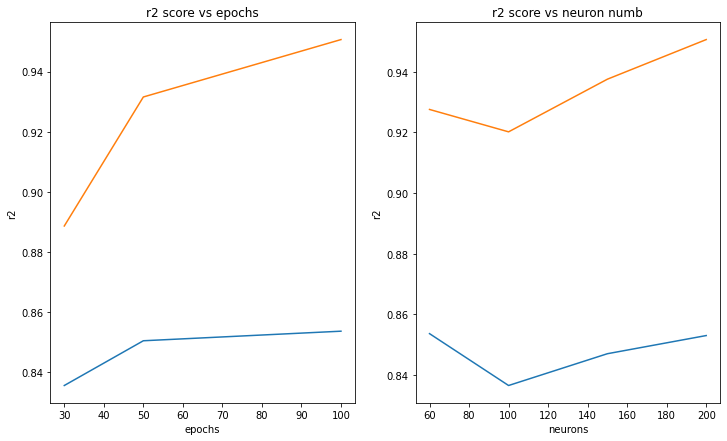

In [662]:
fig, ax = plt.subplots(1, 2, figsize=(12, 7))
plt.subplots_adjust(wspace=0.2)

# plt.figure(figsize = (40,5))
ax[0].set_title('r2 score vs epochs')
ax[0].set_xlabel('epochs')
ax[0].set_ylabel('r2')
ax[0].plot(result.groupby('number of epochs')['val r2 score'].max())
ax[0].plot(result.groupby('number of epochs')['train r2 score'].max())

ax[1].set_title('r2 score vs neuron numb')
ax[1].set_xlabel('neurons')
ax[1].set_ylabel('r2')
ax[1].plot(result.groupby('neuron 1st hidden layer quantity')['val r2 score'].max())
ax[1].plot(result.groupby('neuron 1st hidden layer quantity')['train r2 score'].max())
plt.show()